### 模型创新与数据处理说明

#### 输入与输出数据类型

输入数据形式为三维数组，维度为 `(样本数量, 时间步长, 特征数量)`。每个样本包含一个时间窗口内的特征数据以及相应的电池健康状态（State of Health, SOH）数据。时间步长设定为4，意味着每个样本包含4个连续时间步的数据点。每个时间步提供5个特征，包括 `voltage_measured`（电压测量值）、`current_measured`（电流测量值）、`temperature_measured`（温度测量值）、`current_load`（负载电流）和 `voltage_load`（负载电压）。

输出数据为一维数组，其形状为 `(样本数量, )`，每个值对应于时间窗口结束时的SOH值。模型旨在通过输入的时间步长数据预测下一个时间步的SOH值。

#### 数据集

所使用的数据集来源于NASA电池预测项目中的 `BatteryAgingARC-FY08Q4` 数据文件夹，包含多个 `.mat` 文件。数据集中的每个文件表示一个电池的放电循环数据，所有文件通过递归方式加载。

#### 数据划分

基于电池标签对数据集进行划分。选择 `B0005` 电池的数据作为测试集，其他电池的数据作为训练集。这种基于电池标签的划分确保了模型能够在未见过的电池数据上进行预测，从而提高模型的泛化能力。

#### 数据处理步骤

1. **数据加载**  
   使用 `load_data` 函数加载每个电池的放电循环数据，提取电池的容量信息，并对其进行处理。数据加载步骤将每个周期的数据点提取为特征，包括电压、电流、温度、负载电流和负载电压。

2. **时间序列数据构建**  
   使用 `construct_time_series_data` 函数将每个电池的数据构建为时间序列样本。通过滑动窗口方式生成样本，每个样本包含一个时间窗口内的连续时间步数据以及相应的 SOH 值。这一过程确保输入数据具有时序依赖性，有助于模型捕捉电池衰退的动态特征。

3. **数据归一化**  
   为了提高模型的训练效果，使用 `MinMaxScaler` 对输入特征和输出 SOH 进行归一化处理。通过将数据缩放至相同的数值范围，消除各特征间的尺度差异，从而避免某些特征主导模型的学习过程。

4. **数据集划分**  
   数据依据电池标签进行训练集和测试集的划分。以 `B0005` 作为测试集，其余电池数据作为训练集。这样的划分方式确保了模型对不同电池数据的泛化能力，并通过测试集来验证模型的性能。

#### 模型训练与评估

1. **模型定义**  
   多种神经网络架构被用于模型的定义，包括 RNN、LSTM、GRU、CNN 和 Transformer 等。为了捕捉电池健康状态的复杂动态变化，模型架构特别设计了基于 Transformer 的 CNN-BiLSTM 组合模型，利用注意力机制和双向长短期记忆网络（BiLSTM）增强模型的时序依赖建模能力。

2. **模型训练**  
   模型训练过程中采用了提前停止（Early Stopping）和学习率调整（Learning Rate Scheduling）机制。这两种机制能够有效避免模型过拟合，并通过动态调整学习率加速模型收敛。

3. **模型评估**  
   在测试集上进行预测后，模型通过多种评估指标进行性能验证，包括 MAE（Mean Absolute Error）、RMSE（Root Mean Square Error）、MAPE（Mean Absolute Percentage Error）和 R2（决定系数）。这些指标能够全面衡量模型在电池健康状态预测任务中的表现。

4. **结果可视化**  
   通过绘制预测结果与真实 SOH 值的对比图，直观展示模型的预测性能。同时，通过多模型评估指标对比图，展示不同模型架构的优劣，为模型选择提供参考。

卡尔曼滤波与Transformer-CNN-BiLSTM的结合在电池健康状态（SOH）预测任务中具有显著的创新性。这一组合模型不仅综合了卡尔曼滤波的噪声抑制能力、Transformer的全局依赖捕捉能力、CNN的局部特征提取优势以及BiLSTM的时序依赖建模能力，还通过多阶段处理提升了预测精度和模型的鲁棒性。

---

## 创新点
### 1. **卡尔曼滤波**

卡尔曼滤波在数据预处理阶段的引入，旨在减少传感器数据中的噪声。电池运行数据通常来自于多个传感器，包括电压、电流、温度等，这些数据不可避免地受到传感器误差和环境噪声的影响。卡尔曼滤波通过递归方式，将动态系统的状态估计结合观测数据，能够在多轮迭代中逐步减小误差，生成平滑的估计值，从而有效去除噪声。

**卡尔曼滤波的优势：**
- **噪声抑制**：能够对噪声进行实时估计和抑制，保留数据的核心趋势，使得后续模型可以基于更加准确的特征进行训练。
- **平滑处理**：通过逐步更新，卡尔曼滤波生成的特征值更加平滑，有助于提升模型在复杂时间序列预测中的表现，尤其是对于电池健康状态的长期趋势预测。
- **动态调整**：由于卡尔曼滤波是基于贝叶斯更新的算法，能够适应动态系统中的状态变化，适合电池健康状态这一随时间变化的复杂预测任务。

### 2. **Transformer**

Transformer 模块引入了自注意力机制，能够在处理时间序列数据时有效捕捉长时间依赖关系。相比于传统的循环神经网络，Transformer模型能够在并行计算的情况下处理全局信息，不再依赖于序列式的计算方式。

**Transformer的优势：**
- **全局依赖建模**：自注意力机制通过计算序列内所有时间步的相关性，能够捕捉长距离时间步之间的依赖关系。这对于电池SOH预测尤为关键，因为电池健康状态的变化可能受到多个历史时间步的共同影响。
- **并行化处理**：Transformer能够高效处理长时间序列，相较于传统的LSTM或RNN，计算效率更高，适用于大型电池数据集的快速训练和预测。
- **灵活性**：通过多头自注意力，模型能够从不同的角度学习时间步之间的关系，从而获得更为丰富的特征表示，提升预测精度。

### 3. **CNN**

卷积神经网络（CNN）在该架构中主要用于提取局部特征。电池运行数据不仅存在时间序列的全局依赖，同时在短期内也有强烈的局部关联。CNN通过卷积操作，能够自动学习电压、电流等特征之间的局部依赖关系，从而捕捉数据的短期变化模式。

**CNN的优势：**
- **局部特征提取**：CNN能够高效提取短时间窗口内的特征，识别出局部的电池状态变化。这对于预测下一时间步的SOH值具有重要意义，尤其是在电池健康状态突变时，CNN可以敏锐地捕捉到这些变化。
- **参数共享**：通过卷积核的共享机制，CNN可以减少参数数量，提升模型的计算效率和训练速度。
- **自动特征提取**：CNN可以自动学习和提取不同时间步之间的模式和特征，无需人工设计特征提取方法，提升模型的适应性和泛化能力。

### 4. **BiLSTM**

双向长短期记忆网络（BiLSTM）作为时序建模的重要组件，能够有效捕捉输入序列的前向和后向依赖关系。通过对电池时间序列数据的双向处理，BiLSTM能够对未来的SOH值进行更加准确的预测。

**BiLSTM的优势：**
- **双向信息流**：相比于单向的LSTM，BiLSTM能够同时考虑时间序列的过去和未来，提升对当前时间步的预测精度。这对电池SOH预测任务尤其重要，因为电池的状态变化既受到历史信息的影响，也受到未来变化趋势的影响。
- **时序依赖处理**：LSTM通过引入记忆单元，有效缓解了传统RNN中的长程依赖问题，而BiLSTM则进一步扩展了这一能力，能够更好地建模复杂的电池衰退过程。

### 5. **模型组合的创新**

卡尔曼滤波与Transformer-CNN-BiLSTM的结合模型，将各个组件的优势有机融合在一起，实现了噪声抑制、局部特征提取与全局依赖建模的全方位提升。卡尔曼滤波首先对数据进行噪声平滑处理，去除传感器噪声后，Transformer模块捕捉长距离的全局依赖关系，CNN提取短期局部特征，最终通过BiLSTM的双向时序依赖处理，实现对未来SOH值的高精度预测。

**组合模型的创新与优点：**
- **多层次特征提取**：模型能够同时处理局部的短期特征和全局的长距离依赖关系，从而更加准确地预测电池SOH。
- **噪声抑制与特征增强**：卡尔曼滤波有效减少了传感器数据中的噪声，为后续的深度学习模块提供了更加干净的输入，提高了整体模型的鲁棒性。
- **时序依赖与动态变化建模**：通过BiLSTM处理时序依赖信息，模型能够准确捕捉电池健康状态随时间的复杂变化，实现动态预测。

这种结合将传统信号处理算法与现代深度学习架构有机融合，充分发挥了各自的优势，在电池SOH预测领域中提供了更加精准、鲁棒性更强的解决方案。

In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import platform
if platform.system() == "Windows":
    plt.rcParams['font.family'] = ['SimHei'] # Windows
elif platform.system() == "Darwin":
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # MacOS
plt.rcParams['axes.unicode_minus']=False 

# 预测步长
predict_step = 5

In [2]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 加载 .mat 文件数据
def load_data(file_path, battery):
    mat = loadmat(file_path)  # 加载 .mat 文件
    counter = 0  # 计数器
    dataset = []  # 存储每个样本的数据
    capacity_data = []  # 存储每个周期的容量数据
    
    # 遍历电池数据中的每个周期
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':  # 只处理放电周期
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                    int(row['time'][0][1]),
                                    int(row['time'][0][2]),
                                    int(row['time'][0][3]),
                                    int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            
            # 遍历每个数据点，获取电压、电流、温度等测量值
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter += 1  # 更新计数器

    return [pd.DataFrame(data=dataset,  # 返回电池数据和容量数据的 DataFrame
                        columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                        columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

# 可视化电池健康状态 (SOH)
def visualize_soh(capacity_df, title):
    attrib = ['cycle', 'datetime', 'capacity']
    dis_ele = capacity_df[attrib]
    C = dis_ele['capacity'][0]
    dis_ele['SoH'] = dis_ele['capacity'] / C  # 计算SOH
    
    plot_df = dis_ele.loc[(dis_ele['cycle'] >= 1), ['cycle', 'SoH']]  # 筛选周期数据
    sns.set_style("white")
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df['cycle'], plot_df['SoH'])  # 绘制SOH随周期变化的曲线
    plt.ylabel('SOH')
    plt.xlabel('cycle')
    plt.title(title)
    plt.close()

# 示例：加载并可视化文件夹中的电池数据
folder_path = './1. BatteryAgingARC-FY08Q4'
mat_files = glob.glob(os.path.join(folder_path, '*.mat'))

# 遍历每个 .mat 文件
for mat_file in mat_files:
    battery_name = os.path.basename(mat_file).split('.')[0]  # 提取电池名称
    dataset, capacity = load_data(mat_file, battery_name)  # 加载电池数据
    visualize_soh(capacity, f'Discharge {battery_name}')  # 可视化SOH


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Conv1D, Bidirectional, LSTM, Dropout, Input,
    MultiHeadAttention, LayerNormalization, GlobalMaxPooling1D,MaxPooling1D
)

def transformer_encoder(inputs, embed_dim=32, num_heads=2, ff_dim=32, rate=0.1):
    # 调整输入维度以匹配嵌入维度
    x = Dense(embed_dim)(inputs)

    # 多头自注意力层
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attention_output = Dropout(rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(attention_output + x)

    # 前馈网络
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(ffn_output + out1)


def create_transformer_cnn_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Transformer Encoder
    x = transformer_encoder(inputs)

    # CNN Layer
    x = Conv1D(filters=16, kernel_size=2, padding="same", activation="relu")(x)
    # BiLSTM Layer
    x = Bidirectional(LSTM(32, return_sequences=False))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SimpleRNN, GlobalAveragePooling1D, Dense, GlobalAvgPool1D, Dropout, MaxPooling1D, Bidirectional, Input, Flatten

# 设置全局随机数种子以确保可重复性
tf.random.set_seed(42)
np.random.seed(42)

# 定义GRU模型方法
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(16, input_shape=input_shape))  # GRU层：16个单元，输入形状为input_shape
    model.add(Dropout(0.5))  # Dropout层：防止过拟合，dropout比率为0.5
    model.add(Dense(1, activation='sigmoid'))  # 输出层：1个神经元，使用sigmoid激活函数
    return model

# 定义CNN模型方法
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))  # Conv1D层：16个滤波器，核大小为3，使用ReLU激活函数，padding方式为'same'
    model.add(GlobalAvgPool1D())  # 全局平均池化层
    model.add(Dropout(0.5))  # Dropout层：dropout比率为0.5
    model.add(Dense(1, activation='sigmoid'))  # 输出层：1个神经元，使用sigmoid激活函数
    return model

# 定义RNN模型方法
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(16, input_shape=input_shape))  # SimpleRNN层：16个单元，输入形状为input_shape
    model.add(Dropout(0.5))  # Dropout层：dropout比率为0.5
    model.add(Dense(1, activation='sigmoid'))  # 输出层：1个神经元，使用sigmoid激活函数
    return model

# 定义LSTM模型方法
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(16, input_shape=input_shape))  # LSTM层：16个单元，输入形状为input_shape
    model.add(Dropout(0.5))  # Dropout层：dropout比率为0.5
    model.add(Dense(1, activation='sigmoid'))  # 输出层：1个神经元，使用sigmoid激活函数
    return model

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Conv1D, Bidirectional, LSTM, Dropout, Input,
    MultiHeadAttention, LayerNormalization, GlobalMaxPooling1D, Flatten
)

# Transformer编码器层
def transformer_encoder(inputs, embed_dim=32, num_heads=2, ff_dim=32, rate=0.1):
    x = Dense(embed_dim)(inputs)  # 嵌入层：将输入转换为embed_dim维的向量

    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)  # 多头自注意力：2个头，注意力维度为embed_dim
    attention_output = Dropout(rate)(attention_output)  # Dropout层：dropout比率为0.1
    out1 = LayerNormalization(epsilon=1e-10)(attention_output + x)  # 残差连接和LayerNorm

    ffn_output = Dense(ff_dim, activation="relu")(out1)  # 前馈网络：隐藏层维度为ff_dim，使用ReLU激活函数
    ffn_output = Dense(embed_dim)(ffn_output)  # 输出维度回到embed_dim
    ffn_output = Dropout(rate)(ffn_output)  # Dropout层：dropout比率为0.1
    return LayerNormalization(epsilon=1e-6)(ffn_output + out1)  # 最后的LayerNorm和残差连接

# 定义Transformer模型方法
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)  # 输入层
    x = transformer_encoder(inputs)  # Transformer编码器
    x = Flatten()(x)  # 展平操作，将高维数据转化为一维
    x = Dropout(0.9)(x)  # Dropout层：dropout比率为0.9
    outputs = Dense(1, activation='sigmoid')(x)  # 输出层：1个神经元，使用sigmoid激活函数
    model = Model(inputs=inputs, outputs=outputs)  # 构建模型
    return model

# 定义CNN-BiLSTM模型方法
def create_cnn_bilstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))  # Conv1D层：32个滤波器，核大小为3，使用ReLU激活函数
    model.add(MaxPooling1D(pool_size=2))  # 最大池化层：池化大小为2
    model.add(Bidirectional(LSTM(32, return_sequences=False)))  # 双向LSTM层：32个单元，不返回序列
    model.add(Dropout(0.5))  # Dropout层：dropout比率为0.5
    model.add(Dense(1, activation='sigmoid'))  # 输出层：1个神经元，使用sigmoid激活函数
    return model

# 主方法：根据模型名称返回对应模型
def get_model(model_name, input_shape):
    if model_name == 'RNN':
        return create_rnn_model(input_shape)
    elif model_name == 'LSTM':
        return create_rnn_model(input_shape)
    elif model_name == 'GRU':
        return create_gru_model(input_shape)
    elif model_name == 'CNN':
        return create_cnn_model(input_shape)
    elif model_name == 'CNN-BiLSTM':
        return create_cnn_bilstm_model(input_shape)
    elif model_name == 'Transformer':
        return create_transformer_model(input_shape)
    elif model_name == 'Transformer-CNN-BiLSTM':
        return create_transformer_cnn_bilstm_model(input_shape)
    else:
        raise ValueError(f"Invalid model name: {model_name}")


In [5]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


# 卡尔曼滤波函数
def kalman_filter_fuc(observations, process_variance, measurement_variance, initial_estimate, initial_uncertainty):
    n = len(observations)
    estimates = np.zeros(n)
    estimate = initial_estimate
    uncertainty = initial_uncertainty

    for t in range(n):
        uncertainty += process_variance
        kalman_gain = uncertainty / (uncertainty + measurement_variance)
        estimate += kalman_gain * (observations[t] - estimate)
        uncertainty = (1 - kalman_gain) * uncertainty
        estimates[t] = estimate
    return estimates

# 1. 卡尔曼滤波处理并生成新的features
def apply_kalman_filter(df, features):
    for feature in features:
        df[feature + '_kalman'] = kalman_filter_fuc(
            df[feature].values, process_variance=1e-4, measurement_variance=0.5**2, initial_estimate=0.0, initial_uncertainty=1.0
        )
    all_features = features + [f + '_kalman' for f in features]
    return df, all_features

# 构建时间序列数据
def construct_time_series_data(data, window_size, predict_step=1):
    X = []
    y = []
    battery_label = []
    cycle_labels = []
    
    for battery_name, df in data.items():
        # 计算SOH
        attrib = ['cycle', 'datetime', 'capacity']
        dis_ele = df[attrib].copy()
        C = dis_ele['capacity'][0]
        dis_ele['SoH'] = dis_ele['capacity']

        # 按cycle分组并计算平均值
        df_grouped = df.groupby('cycle').mean().reset_index()

        # 确保所有需要的列都存在
        required_columns = ['voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
        if not all(col in df_grouped.columns for col in required_columns):
            print(f"Warning: Missing columns in battery {battery_name}. Skipping this battery.")
            continue
        
        # 应用卡尔曼滤波器
        df_grouped, all_features = apply_kalman_filter(df_grouped, required_columns)

        features = df_grouped[all_features].values  # 使用原始和卡尔曼滤波后的特征
        soh_values = dis_ele.groupby('cycle').mean()['SoH'].values
        cycle_values = df_grouped['cycle'].values
        
        for i in range(len(soh_values) - window_size - predict_step + 1):
            feature_window = np.hstack([features[i:i+window_size], soh_values[i:i+window_size].reshape(-1, 1)])
            X.append(feature_window)
            y.append(soh_values[i+window_size + predict_step - 1])  # 预测未来第predict_step个值
            battery_label.append(battery_name)
            cycle_labels.append(cycle_values[i+window_size + predict_step - 1])  # 对应的cycle标签改为未来predict_step的cycle值
    
    X = np.array(X)
    y = np.array(y)
    battery_label = np.array(battery_label)
    cycle_labels = np.array(cycle_labels)
    
    return X, y, battery_label, cycle_labels


# 加载文件夹中的数据
folder_path = './Dataset/1. BatteryAgingARC-FY08Q4'

mat_files = glob.glob(os.path.join(folder_path, '**', '*.mat'), recursive=True)

data = {}
for mat_file in mat_files:
    battery_name = os.path.basename(mat_file).split('.')[0]
    try:
        dataset, _ = load_data(mat_file, battery_name)
    except:
        # print(f"Error: {mat_file}")
        pass
    data[battery_name] = dataset 

# 构建时间序列数据，指定窗口大小和预测步长
window_size = 4
X, y, battery_label, cycle_labels = construct_time_series_data(data, window_size, predict_step=predict_step)

# 定义归一化和反归一化的函数
scaler_X = MinMaxScaler()  # 用于特征数据的归一化
scaler_y = MinMaxScaler()  # 用于目标数据的归一化

# 归一化函数
def normalize_data(X, y):
    X_reshaped = X.reshape(-1, X.shape[-1])  # 将X重塑为2D数组以适应scaler
    X_normalized = scaler_X.fit_transform(X_reshaped).reshape(X.shape)  # 对X进行归一化并恢复原形状
    
    y_reshaped = y.reshape(-1, 1)  # 将y重塑为2D数组以适应scaler
    y_normalized = scaler_y.fit_transform(y_reshaped).reshape(y.shape)  # 对y进行归一化并恢复原形状
    
    return X_normalized, y_normalized

# 反归一化函数
def denormalize_data(y_normalized):
    y_reshaped = y_normalized.reshape(-1, 1)  # 将y_normalized重塑为2D数组
    y_denormalized = scaler_y.inverse_transform(y_reshaped).reshape(y_normalized.shape)  # 反归一化并恢复原形状
    return y_denormalized

# 归一化特征和目标数据
X_normalized, y_normalized = normalize_data(X, y)

# 设置测试电池标签，用于划分训练集和测试集
test_label = 'B0005'  # 指定测试电池

# 划分训练集和测试集
X_train = X_normalized[battery_label != test_label]  # 训练集为不属于测试电池的数据
y_train = y_normalized[battery_label != test_label]
X_test = X_normalized[battery_label  == test_label]  # 测试集为属于指定测试电池的数据
y_test = y_normalized[battery_label == test_label]
cycle_labels_test = cycle_labels[battery_label == test_label]  # 测试集的cycle标签


In [6]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# 设定全局随机数种子
set_seed(0)

epochs_dict = {
    'Transformer': 9,
    'Transformer-CNN-BiLSTM':100
}

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, cycle_labels_test, epochs_dict):
    # 获取模型
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = get_model(model_name, input_shape)

    # 编译模型
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # 获取训练次数
    epochs = epochs_dict.get(model_name, 2)

    # 设置EarlyStopping和ReduceLROnPlateau回调
    early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-8)

    # 训练模型
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, verbose=0,
                        callbacks=[early_stopping, reduce_lr])

    # 获取最佳权重
    if early_stopping.best_weights:
        model.set_weights(early_stopping.best_weights)

    # 对测试集进行预测
    y_pred_normalized = model.predict(X_test)
    y_pred = denormalize_data(y_pred_normalized)
    y_test_denormalized = denormalize_data(y_test)

    # 将capacity转换为SOH
    C_max = data[test_label]['capacity'].max()
    y_test_soh = y_test_denormalized.flatten() / C_max
    y_pred_soh = y_pred.flatten() / C_max

    # 根据cycle求和
    cycle_df = pd.DataFrame({'cycle': cycle_labels_test, 'true_soh': y_test_soh, 'predicted_soh': y_pred_soh})
    cycle_grouped = cycle_df.groupby('cycle').mean()

    # 画出soh的真实曲线和预测曲线并保存
    plt.figure(figsize=(10, 6))
    plt.plot(cycle_grouped.index, cycle_grouped['true_soh'], label='True SOH')
    plt.plot(cycle_grouped.index, cycle_grouped['predicted_soh'], label='Predicted SOH')
    plt.xlabel('Cycle')
    plt.ylabel('SOH')
    plt.legend()
    plt.title(f'{model_name} - True SOH vs Predicted SOH')
    plt.savefig(f'{model_name}_soh_plot.png',dpi=500)
    plt.close()

    # 计算指标
    mae, rmse, mape, r2 = calculate_metrics(y_test_soh, y_pred_soh)
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2}

print("Training... Please wait...")
# 训练和评估所有模型
metrics_dict = {}
model_names = ['CNN','LSTM','RNN','GRU','CNN-BiLSTM','Transformer','Transformer-CNN-BiLSTM']
for model_name in model_names:
    metrics = train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, cycle_labels_test, epochs_dict)
    metrics_dict[model_name] = metrics
    # print(f'{model_name} metrics: {metrics}')

# 打印结果字典
print(metrics_dict)

Training... Please wait...
5/5 [==============================] - 0s 3ms/step
{'CNN': {'mae': 0.0595095569844273, 'rmse': 0.06718639453388284, 'mape': 0.07131578422393148, 'r2': 0.5442504864589424}, 'LSTM': {'mae': 0.050870904585691434, 'rmse': 0.05735558794129067, 'mape': 0.06094766844629114, 'r2': 0.667864716647752}, 'RNN': {'mae': 0.044459581609307665, 'rmse': 0.051435073354653645, 'mape': 0.055872967877508194, 'r2': 0.7328948454345144}, 'GRU': {'mae': 0.04775376072029338, 'rmse': 0.05423459118947284, 'mape': 0.05727416466905018, 'r2': 0.7030274666849035}, 'CNN-BiLSTM': {'mae': 0.020287591730765414, 'rmse': 0.024224721542089395, 'mape': 0.023068149579297308, 'r2': 0.9407509857454661}, 'Transformer': {'mae': 0.026385075776483247, 'rmse': 0.029513591765876403, 'mape': 0.03203504958222521, 'r2': 0.9120557046346837}, 'Transformer-CNN-BiLSTM': {'mae': 0.01024102541898508, 'rmse': 0.014194274487403832, 'mape': 0.011615760477868314, 'r2': 0.9796581737429173}}


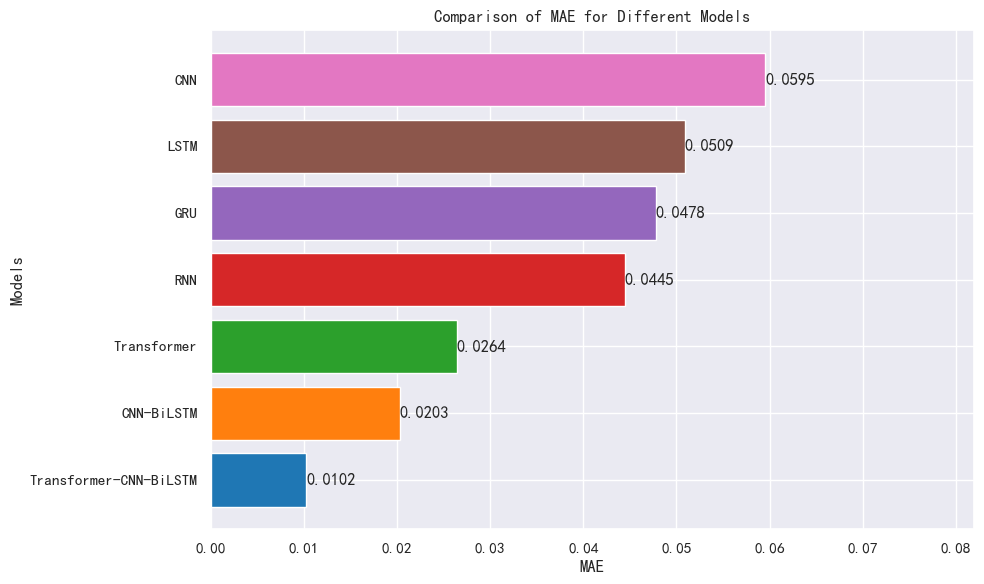

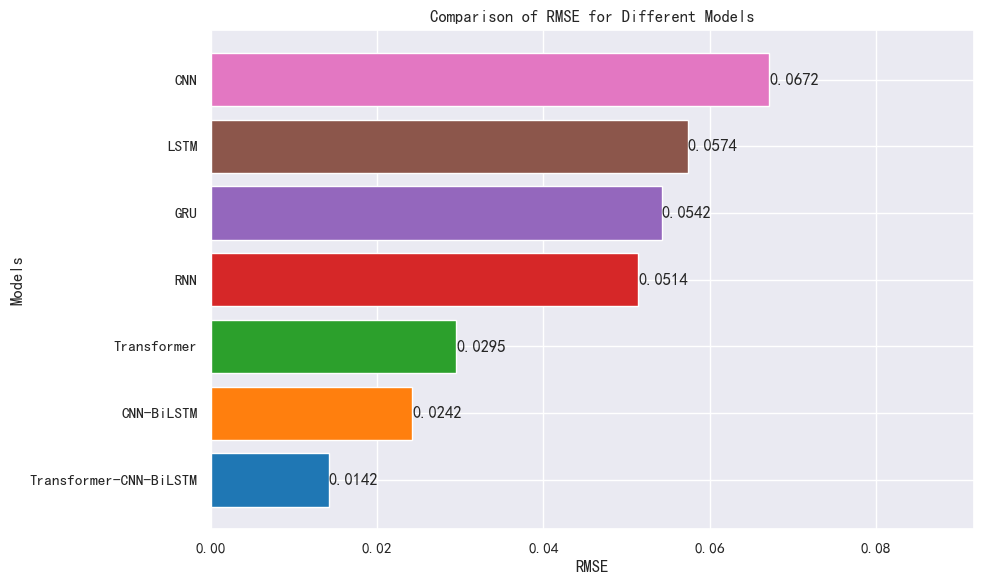

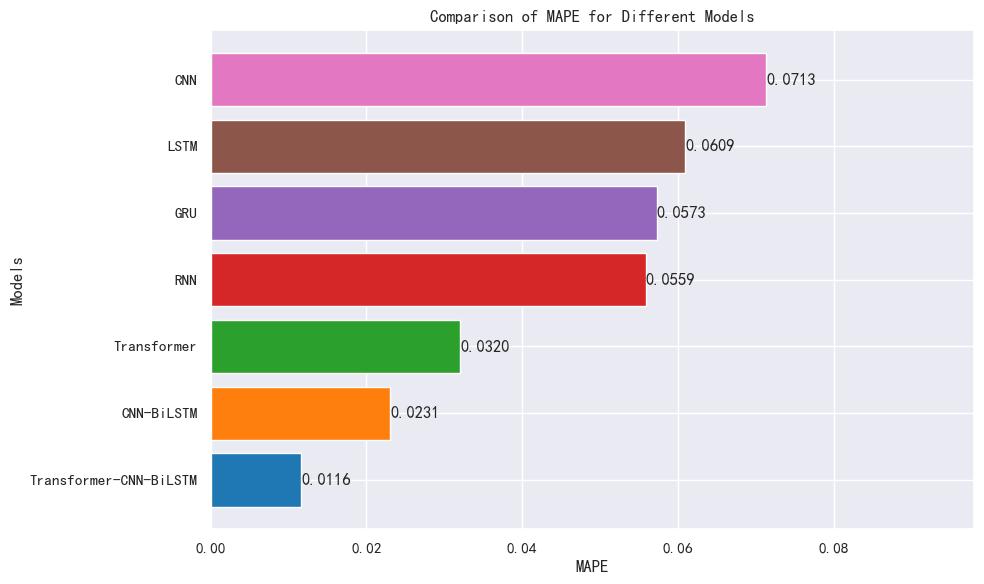

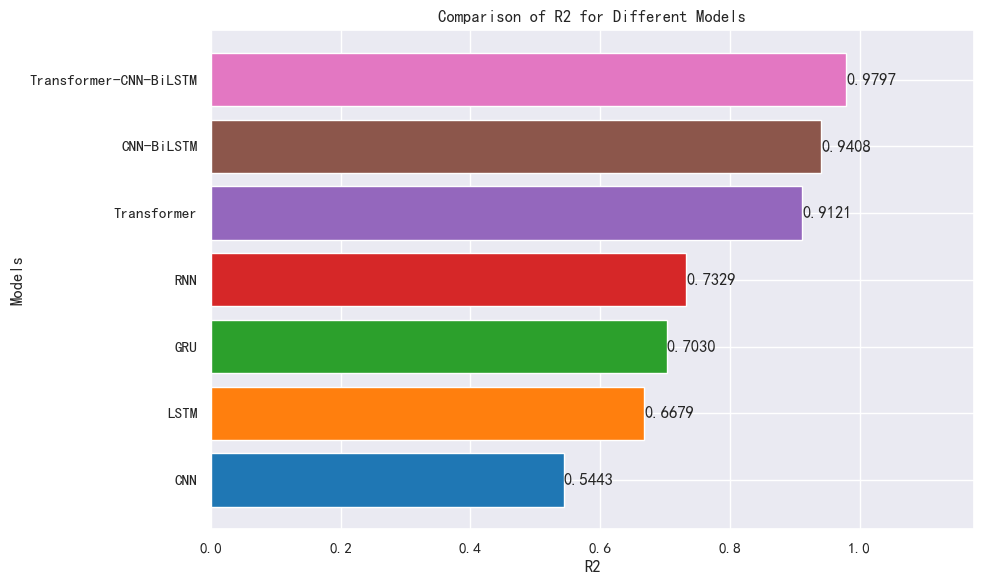

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制指标对比图并保存
def plot_metrics_comparison(metrics_dict):
    metrics = ['mae', 'rmse', 'mape', 'r2']
    model_names = list(metrics_dict.keys())
    cmap = plt.get_cmap('tab10')  # 使用plt的cmap选择颜色
    
    for metric in metrics:
        # 获取对应指标的值并排序
        values = np.array([metrics_dict[model][metric] for model in model_names])
        sorted_indices = np.argsort(values)[::]  # 从高到低排序
        sorted_model_names = [model_names[i] for i in sorted_indices]
        sorted_values = values[sorted_indices]
        
        # 计算ylim
        min_value = sorted_values.min()
        max_value = sorted_values.max()
        avg_value = sorted_values.mean()
        ylim = [0, max_value + (max_value - avg_value)]
        
        plt.figure(figsize=(10, 6))
        bars = plt.barh(sorted_model_names, sorted_values, color=cmap(range(len(model_names))))
        plt.xlim(ylim)
        plt.xlabel(metric.upper())
        plt.ylabel('Models')
        plt.title(f'Comparison of {metric.upper()} for Different Models')

        # 在每个条形图上标记具体数值
        for bar in bars:
            xval = bar.get_width()
            plt.text(xval, bar.get_y() + bar.get_height()/2, f'{xval:.4f}', va='center', ha='left')
        plt.tight_layout()
        plt.savefig(f'{metric}_comparison.png')
        plt.show()

# 调用函数绘制并保存图形
plot_metrics_comparison(metrics_dict)
